In [1]:
import numpy as np
import matplotlib.pylab as plt
import torch

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
from torchvision import datasets, transforms

# Preparing Data

In [4]:
pic_size = 8

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../mnist', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(size=(pic_size, pic_size)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=64, shuffle=False)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../mnist', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(size=(pic_size, pic_size)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=64, shuffle=False)

In [5]:
train_loader_generator = iter(train_loader)

# Quine itself 

In [6]:
class AuxuliaryQuine(nn.Module):
    
    def __init__(self, input_size = 1, embedding_size = pic_size*pic_size, layer_size = pic_size*pic_size, output_size = 1, output_class_size = 10):
        super(AuxuliaryQuine, self).__init__()
        
        self.linear_layer_size = embedding_size * layer_size
        
        self.embedding = nn.Embedding(embedding_dim=embedding_size, num_embeddings=self.get_num_of_parameters())
        self.linear = nn.Linear(embedding_size, layer_size, bias=False)
        
        self.output = nn.Linear(layer_size, output_size, bias=False)
        self.class_output = nn.Linear(layer_size, output_class_size, bias=False)
        
    def forward(self, x1, x2):
        
        # parameter index input
        z = self.embedding(x1)
        z = F.selu(self.linear(z))
        out = self.output(z)
        
        # actual image input
        x2 = x2.view(-1, pic_size*pic_size)
        z = F.selu(self.linear(x2))        
        out_class = self.class_output(z)
        
        return out, out_class
        
    def get_num_of_parameters(self):
        return self.linear_layer_size
    
    def flatten_parameteres(self):
        return self.linear.weight.view(-1)
    
    def replace_weights(self, layer_id, target_tensor):
        if layer_id == 1:
            self.linear.weight = nn.Parameter(target_tensor)
        else:
            pass

# Training Regeneration

In [60]:
qq = AuxuliaryQuine()

In [61]:
qq

AuxuliaryQuine(
  (embedding): Embedding(4096, 64)
  (linear): Linear(in_features=64, out_features=64, bias=False)
  (output): Linear(in_features=64, out_features=1, bias=False)
  (class_output): Linear(in_features=64, out_features=10, bias=False)
)

In [62]:
criterion_parameters = nn.MSELoss()
criterion_classification = nn.CrossEntropyLoss()
optimizer = optim.AdamW(qq.parameters(), lr=0.002)

generation_epochs = 10
optimization_epochs = 3
optimization_iterations = 100
batch_size = 64

lambda_param = 1.0
lambda_class = 1e-4

In [63]:
stats = {
    'Quine loss': [],
    'Classification loss': [],
    'Total loss': []
}

for g_epoch in range(generation_epochs):

    # optimization step
    for o_epoch in range(optimization_epochs):
        
        for i in range(optimization_iterations):
            
            optimizer.zero_grad()
            
            random_indices = torch.LongTensor(np.random.randint(qq.get_num_of_parameters(), size = (batch_size, )))
            
            try:
                data, target = next(train_loader_generator)
            except:
                train_loader_generator = iter(train_loader)
                data, target = next(train_loader_generator)
                
            pred = qq(random_indices, data)

            y = pred[0]
            y_h = torch.Tensor(qq.flatten_parameteres())[random_indices].reshape(-1, 1)

            y_c = pred[1]
            y_c_h = target

            loss1 = criterion_parameters(y, y_h) * lambda_param
            loss2 = criterion_classification(y_c, y_c_h) * lambda_class
            loss = loss1 + loss2
            
            stats['Quine loss'].append(loss1.detach().numpy().tolist())
            stats['Classification loss'].append(loss2.detach().numpy().tolist())
            stats['Total loss'].append(loss.detach().numpy().tolist())

            loss.backward()
            optimizer.step()
   
    # regeneration step
    all_indices = torch.LongTensor(np.arange(0, (pic_size*pic_size)**2).reshape(pic_size*pic_size, pic_size*pic_size))
    random_image = torch.Tensor(np.random.random(size=(pic_size, pic_size)))
    l = qq(all_indices, random_image)[0]
    qq.replace_weights(1, l.squeeze())
    
    print(g_epoch, loss)

0 tensor(0.0042, grad_fn=<AddBackward0>)
1 tensor(0.0006, grad_fn=<AddBackward0>)
2 tensor(0.0002, grad_fn=<AddBackward0>)
3 tensor(0.0001, grad_fn=<AddBackward0>)
4 tensor(9.2931e-05, grad_fn=<AddBackward0>)
5 tensor(6.6110e-05, grad_fn=<AddBackward0>)
6 tensor(8.4074e-05, grad_fn=<AddBackward0>)
7 tensor(6.6614e-05, grad_fn=<AddBackward0>)
8 tensor(6.2027e-05, grad_fn=<AddBackward0>)
9 tensor(6.7616e-05, grad_fn=<AddBackward0>)


# Evalution

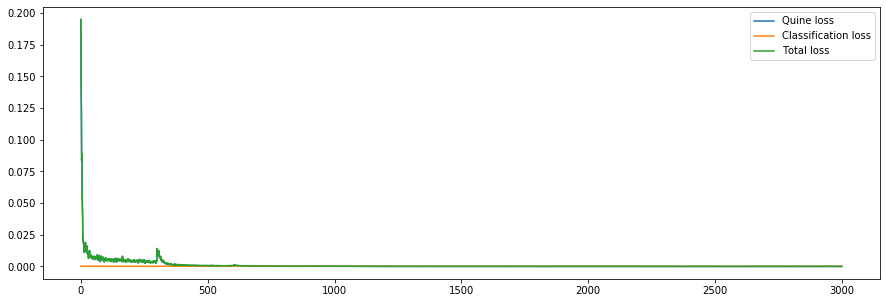

In [64]:
plt.figure(figsize = (15, 5))
plt.plot(stats['Quine loss'], label = 'Quine loss')
plt.plot(stats['Classification loss'], label = 'Classification loss')
plt.plot(stats['Total loss'], label = 'Total loss')
plt.legend()
plt.show()

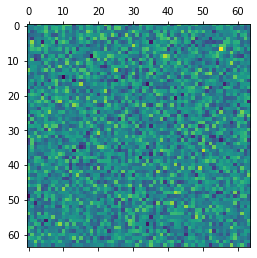

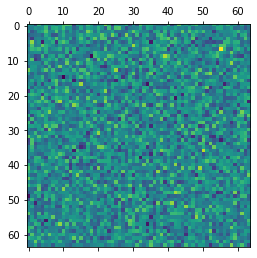

In [65]:
qq_index = 1
index1, index2 = 0, (pic_size*pic_size)**2
reshape1, reshape2 = pic_size*pic_size, pic_size*pic_size

index_input = torch.LongTensor(np.arange(index1, index2).reshape(reshape1, reshape2))
random_image = torch.Tensor(np.random.random(size=(pic_size, pic_size)))

real = list(qq.parameters())[qq_index].detach().numpy().reshape(reshape1, reshape2)
pred = qq(index_input, random_image)[0].detach().squeeze().numpy()

plt.matshow(real)
plt.matshow(pred)

5.4129545e-05 0.023294415
5.3504773e-05 0.023270465


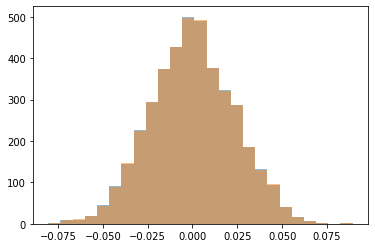

In [66]:
print(real.flatten().mean(), real.flatten().std())
print(pred.flatten().mean(), pred.flatten().std())

plt.figure()
plt.hist(real.flatten(), bins = 25, alpha = 0.5)
plt.hist(pred.flatten(), bins = 25, alpha = 0.5)
plt.show()

In [67]:
correct_cnt = 0
total_cnt = 0

for batch_idx, (x, target) in enumerate(test_loader):
    x, target = Variable(x, volatile=True), Variable(target, volatile=True)
    random_indices = torch.LongTensor(np.random.random(size=(pic_size*pic_size, )))
    out = qq(random_indices, x)[1]
    _, pred_label = torch.max(out.data, 1)
    total_cnt += x.data.size()[0]
    correct_cnt += (pred_label == target.data).sum()
    
print('Test accuracy', correct_cnt.numpy().tolist() / total_cnt)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


Test accuracy 0.8455


# Regular Neural Network

In [15]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, embedding_size = pic_size*pic_size, layer_size = pic_size*pic_size, output_class_size = 10):
        super(NeuralNetwork, self).__init__()

        self.linear = nn.Linear(embedding_size, layer_size, bias=False)        
        self.class_output = nn.Linear(layer_size, output_class_size, bias=False)
        
    def forward(self, x2):

        x2 = x2.view(-1, pic_size*pic_size)
        z = F.selu(self.linear(x2))        
        out_class = self.class_output(z)
        
        return out_class

In [16]:
net = NeuralNetwork()

In [17]:
net

NeuralNetwork(
  (linear): Linear(in_features=64, out_features=64, bias=False)
  (class_output): Linear(in_features=64, out_features=10, bias=False)
)

In [18]:
criterion_classification = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.002)

generation_epochs = 10
optimization_epochs = 3
optimization_iterations = 100
batch_size = 64

In [19]:
stats = {
    'Total loss': []
}

for g_epoch in range(generation_epochs):

    for o_epoch in range(optimization_epochs):        
        for i in range(optimization_iterations):
            
            optimizer.zero_grad()

            try:
                data, target = next(train_loader_generator)
            except:
                train_loader_generator = iter(train_loader)
                data, target = next(train_loader_generator)
                
            pred = net(data)

            y_c = pred
            y_c_h = target

            loss = criterion_classification(y_c, y_c_h)
            stats['Total loss'].append(loss.detach().numpy().tolist())

            loss.backward()
            optimizer.step()

    print(g_epoch, loss)

0 tensor(0.4402, grad_fn=<NllLossBackward>)
1 tensor(0.2940, grad_fn=<NllLossBackward>)
2 tensor(0.4414, grad_fn=<NllLossBackward>)
3 tensor(0.9598, grad_fn=<NllLossBackward>)
4 tensor(0.1321, grad_fn=<NllLossBackward>)
5 tensor(0.4602, grad_fn=<NllLossBackward>)
6 tensor(0.1497, grad_fn=<NllLossBackward>)
7 tensor(0.2233, grad_fn=<NllLossBackward>)
8 tensor(0.1008, grad_fn=<NllLossBackward>)
9 tensor(0.1526, grad_fn=<NllLossBackward>)


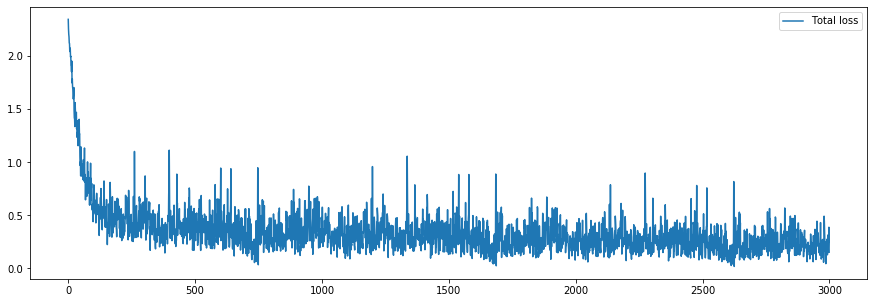

In [20]:
plt.figure(figsize = (15, 5))
plt.plot(stats['Total loss'], label = 'Total loss')
plt.legend()
plt.show()

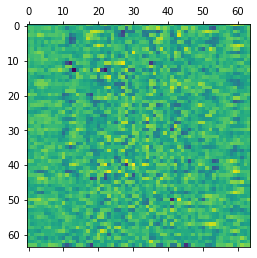

In [21]:
reshape1, reshape2 = pic_size*pic_size, pic_size*pic_size
real = list(net.parameters())[0].detach().numpy().reshape(reshape1, reshape2)
plt.matshow(real)

0.003914912 0.1980911


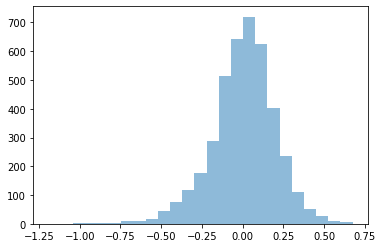

In [22]:
print(real.flatten().mean(), real.flatten().std())

plt.figure()
plt.hist(real.flatten(), bins = 25, alpha = 0.5)
plt.show()

In [23]:
correct_cnt = 0
total_cnt = 0

for batch_idx, (x, target) in enumerate(test_loader):
    x, target = Variable(x, volatile=True), Variable(target, volatile=True)
    out = net(x)
    _, pred_label = torch.max(out.data, 1)
    total_cnt += x.data.size()[0]
    correct_cnt += (pred_label == target.data).sum()
    
print('Test accuracy', correct_cnt.numpy().tolist() / total_cnt)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


Test accuracy 0.9382
